In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import scipy.io as sio
import pandas as pd
import time
import cv2

In [23]:
path_data='/content/drive/MyDrive/dataset/dataset_classes/'
folders=glob.glob(path_data+'*')
classes=np.array(['MISC', 'CIRC', 'CALC', 'SPIC', 'ASYM', 'ARCH', 'NORM'])

In [24]:
data_id=[]
for i in folders:
  print(i[i.rfind('/')+1:])
  if i==0:
    data_id=np.array(glob.glob(i+'/m*'))
  else:
    images=np.array(glob.glob(i+'/m*'))
    data_id=np.concatenate((data_id, images))

MISC
CIRC
CALC
SPIC
ASYM
ARCH
NORM


In [25]:
def remove(strg):
  return strg[47:] 
removv=np.vectorize(remove)

In [26]:
inds_x=removv(data_id)

In [27]:
def get_data(x_id, Fourier=False):
  if Fourier:
    pos=x_id.find('/')+1
    name=x_id[:pos]+'Fourier_'+x_id[pos:]
  else:
    name=x_id
  ima = cv2.imread(path_data+name)
  lab=np.where(classes==x_id[:x_id.find('/')])[0][0]
  return ima, int(lab)

In [28]:
def one_hot(vec):
  vec = vec
  shape = (vec.size, 7)
  one = np.zeros(shape)
  rows = np.arange(vec.size)
  one[rows, vec.astype('int')] = 1
  return one

In [29]:
'''from keras.utils import Sequence
class Sequence_data(Sequence):
    def __init__(self, data, batch_size, is_training, rotation):
        self.data = data
        self.batch_size = batch_size
        self.is_training = is_training
        self.rotation=rotation

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = []
        Y = []

        for n, path in enumerate(batch_x):
          data_x, data_y = get_data(path)
          X.append(data_x)
          Y.append(data_y)
          if self.is_training:
            data_x, data_y = get_data(path, True)
            X.append(data_x)
            Y.append(data_y)          
        X = np.array(X)
        Y = np.array(Y)

        if self.rotation:
          X=np.concatenate((X, np.rot90(X, 1, axes=(1,2)),np.rot90(X, 2, axes=(1,2)),np.rot90(X, 3, axes=(1,2))))
          Y=np.concatenate((Y,Y,Y,Y))

        return X, one_hot(Y)'''

'from keras.utils import Sequence\nclass Sequence_data(Sequence):\n    def __init__(self, data, batch_size, is_training, rotation):\n        self.data = data\n        self.batch_size = batch_size\n        self.is_training = is_training\n        self.rotation=rotation\n\n    def __len__(self):\n        return int(np.ceil(len(self.data) / float(self.batch_size)))\n\n    def __getitem__(self, idx):\n        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]\n        \n        X = []\n        Y = []\n\n        for n, path in enumerate(batch_x):\n          data_x, data_y = get_data(path)\n          X.append(data_x)\n          Y.append(data_y)\n          if self.is_training:\n            data_x, data_y = get_data(path, True)\n            X.append(data_x)\n            Y.append(data_y)          \n        X = np.array(X)\n        Y = np.array(Y)\n\n        if self.rotation:\n          X=np.concatenate((X, np.rot90(X, 1, axes=(1,2)),np.rot90(X, 2, axes=(1,2)),np.rot90(X, 3, a

In [30]:
def get_index(inds_0):
  subx=np.shape(inds_0)[0]
  rando_ind=np.random.choice(subx,subx,replace=False)

  idx=inds_0[rando_ind]

  train_id=idx[:int(subx*0.7)]
  valid_id=idx[int(subx*0.7):int(subx*0.85)]
  test_id =idx[int(subx*0.85):]
  return train_id, valid_id, test_id

In [31]:
kernel=[(0,0), (0,2), (1,1), (1,3), (2,0), (2,2), (3,1), (3,3)]
def get_ima(tam, pk, ima, x_id):
  ver=np.zeros((tam,tam))
  hor=np.zeros((tam,tam))
  ver[np.arange(tam)%4==kernel[pk][0],:]=1
  hor[:,np.arange(tam)%4==kernel[pk][1]]=1
  ima=ima[...,0]
  ima=ima[ver*hor==1].reshape((int(tam/4),int(tam/4)))
  if kernel[pk][0]>=2:
    ima=np.flip(ima, axis=0)
  ima=np.rot90(ima,kernel[pk][1])
  lab=np.where(classes==x_id[:x_id.find('/')])[0][0]
  return ima, int(lab)

In [32]:
def get_data_reduction(x_id, Fourier=False, pk=np.random.choice(8), aug=True):
  tam=1024
  if Fourier:
    pos=x_id.find('/')+1
    name=x_id[:pos]+'Fourier_'+x_id[pos:]
  else:
    name=x_id
  ima = cv2.imread(path_data+name)  
  if np.shape(ima)[0]!=tam:
    print('Size error')
  else:
    if aug:
      imaOu=np.zeros((8,int(tam/4),int(tam/4)))
      lab2=[]
      for pk in range(8):
        im, la=get_ima(tam, pk, ima, x_id)
        imaOu[pk]=im
        lab2=np.append(lab2,la)
      return imaOu, lab2
    else:
      return get_ima(tam, pk, ima, x_id)

In [33]:
xx, yy=get_data_reduction(inds_x[0], aug=True)
np.shape(xx), np.shape(yy)

((8, 256, 256), (8,))

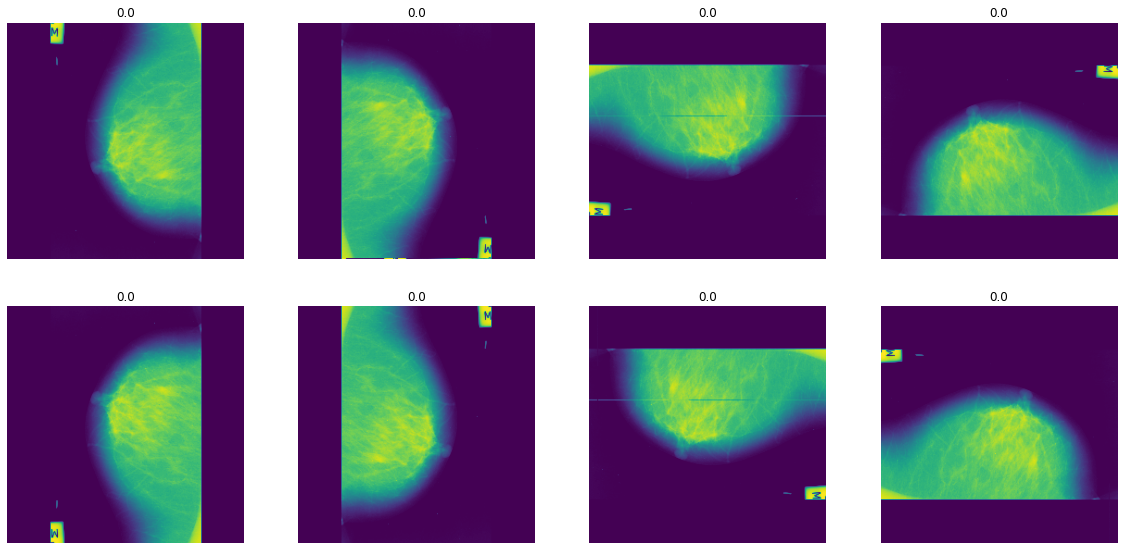

In [34]:
plt.figure(figsize=(20,20))
for i in range(8):
  plt.subplot(4,4,i+1)
  plt.title(yy[i])
  plt.imshow(xx[i])
  plt.axis('off')

In [35]:
import tensorflow as tf

In [36]:
def get_test_data(test_id):
  xx_test=[]
  yx_test=[]
  for n, i in enumerate(test_id):
    uno,dos=get_data(i)
    xx_test.append(uno)
    yx_test.append(dos)
  test_x=np.array(xx_test)
  test_y=np.array(yx_test)
  return test_x, one_hot(test_y)

In [37]:
def get_matrix(ind_0, aug=False, rgb=True):
  sz=np.shape(ind_0)[0]
  ima,lab=get_data_reduction(ind_0[0], aug=aug)
  szx=np.shape(ima)
  mat=np.zeros((sz*(1+int(aug)*7),szx[0+int(aug)],szx[1+int(aug)]))
  labels=[]

  for n,ix in enumerate(ind_0):
    ima,lab=get_data_reduction(ix, aug=aug)
    mat[n*(1+int(aug)*7):(n+1)*(1+int(aug)*7)]=ima
    labels=np.append(labels, lab)
    print("\rprocess ", round((n+1)*100/sz, 2), "%", end="")
  mat=tf.convert_to_tensor(mat.reshape(np.shape(mat)+(1,)))
  labels=tf.convert_to_tensor(one_hot(labels))
  if rgb:
    return tf.image.grayscale_to_rgb(mat), labels
  else:
    return mat, labels

In [38]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [39]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [40]:
train,valid,test=get_index(inds_x)
x_train, y_train=get_matrix(train, True)
x_valid, y_valid=get_matrix(valid, True)
x_test , y_test =get_matrix(test,  True)

process  100.0 %

In [41]:
from tensorflow.keras import applications as ap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [42]:
Networs=['DenseNet121', 'InceptionResNetV2', 'ResNet50V2', 'VGG19', 'Xception', 'InceptionV3']
def get_model(network, opt='adadelta', loss_name='categorical_crossentropy', input_shape=(256,256,3)):
  try:
    del model
  except:
    print('done')
  model=Sequential()
  if network=='ResNet50V2':
    model.add(ap.ResNet50V2(include_top=False, input_shape=input_shape, pooling='avg', classes=7)) # The input must have 3 channels
  if network=='EfficientNetB7':
    model.add(ap.EfficientNetB7(include_top=False, input_shape=input_shape, pooling='avg', classes=7)) 
  if network=='InceptionResNetV2':
    model.add(ap.InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg', classes=7)) 
  if network=='InceptionV3':
    model.add(ap.InceptionV3(include_top=False, input_shape=input_shape, pooling='avg', classes=7)) 
  if network=='NASNetLarge':
    model.add(ap.NASNetLarge(include_top=False, input_shape=input_shape, pooling='avg', classes=7))
  if network=='VGG19':
    model.add(ap.VGG19(include_top=False, input_shape=input_shape, pooling='avg', classes=7)) 
  if network=='Xception':
    model.add(ap.Xception(include_top=False, input_shape=input_shape, pooling='avg', classes=7))
  if network=='DenseNet121':
    model.add(ap.DenseNet121(include_top=False, input_shape=input_shape, pooling='avg', classes=7))
  
  model.add(Dense(7, activation='softmax'))
  model.compile(optimizer=opt, loss=loss_name, metrics=['acc', tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives()])
  return model

In [43]:
df = pd.DataFrame(columns=('run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time', 'augm', 'Class', 'TP', 'TN', 'FP', 'FN','result_mat'))
df.head()

,run_n,network,optimizer,loss,epochs,total_parameters,time,augm,Class,TP,TN,FP,FN,result_mat


In [44]:
from IPython.display import clear_output

path2='/content/drive/MyDrive/INDIGO_MLR/3_CancerDeMama/data_augmentation/'
pathW='/content/drive/MyDrive/INDIGO_MLR/3_CancerDeMama/Weights/'
augmentation='partsRotated'
optimizer='adadelta'
epochs=40
loss='categorical_crossentropy'

In [45]:
TP=tf.keras.metrics.TruePositives()
TN=tf.keras.metrics.TrueNegatives()
FP=tf.keras.metrics.FalsePositives()
FN=tf.keras.metrics.FalseNegatives()

In [ ]:
y_test=y_test>=0.5
for net in Networs:

  name_0='_'.join(['clasification_t',augmentation,net,optimizer])
  if not os.path.exists(path2+name_0+'.csv'):
    df.to_csv(path2+name_0+'.csv')

  for i in range(40): #Numero corridas 
    for j in [loss]: #Funciones de perdida
      cntn=True
      name_m='_'.join([name_0,j,'run',str(i)])  
      print(name_m)

      model=get_model(net, 'Adam', 'categorical_crossentropy')
      
      try:
        tic = time.time()
        results = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs)
        toc=time.time()-tic
        model.save_weights(pathW+name_m+"w.h5")
      except:
        print('Training error')
        cntn=False

      if cntn:
        sio.savemat(pathW+name_m+'_r.mat', results.history)

        #Validation
        y_hat=np.array(model.predict(x_test))
        sio.savemat(pathW+name_m+'_los_8.mat',{'y_hat': y_hat, 'y_test': np.array(y_test)})
        y_hat=y_hat>=0.5

        for class_i in range(7):
          TP.reset_state()
          TN.reset_state()
          FP.reset_state()
          FN.reset_state()        

          TP.update_state(y_test[:,class_i], y_hat[:,class_i])
          TN.update_state(y_test[:,class_i], y_hat[:,class_i])
          FP.update_state(y_test[:,class_i], y_hat[:,class_i])
          FN.update_state(y_test[:,class_i], y_hat[:,class_i])
          total_p=model.count_params()

          #data frame
          df2=pd.read_csv(path2+name_0+'.csv')
          df2=df2.append({'run_n': i,
                        'network': net,
                        'optimizer': optimizer,
                        'loss': 'categorical_crossentropy',
                        'epochs': epochs,
                        'total_parameters': total_p,
                        'time': toc,
                        'augm': augmentation,
                        'Class': class_i,
                        'TP': float(TP.result()),
                        'TN': float(TN.result()),
                        'FP': float(FP.result()),
                        'FN': float(FN.result()),
                        'result_mat': name_m+'_r.mat'} , ignore_index=True)
          df2=df2.drop(df2.columns[:np.where(df2.columns=='run_n')[0][0]], axis=1)
          df2.to_csv(path2+name_0+'.csv')
        clear_output(wait=True)

clasification_t_partsRotated_ResNet50V2_adadelta_categorical_crossentropy_run_21
done
Epoch 1/40
64/64 [==============================] - 15s 152ms/step - loss: 1.8110 - acc: 0.2968 - recall_101: 0.0620 - false_positives_102: 133.0000 - val_loss: 74.1150 - val_acc: 0.1455 - val_recall_101: 0.1455 - val_false_positives_102: 376.0000
Epoch 2/40
64/64 [==============================] - 9s 137ms/step - loss: 1.2929 - acc: 0.5212 - recall_101: 0.2953 - false_positives_102: 224.0000 - val_loss: 3223.4812 - val_acc: 0.2364 - val_recall_101: 0.2364 - val_false_positives_102: 336.0000
Epoch 3/40
64/64 [==============================] - 9s 136ms/step - loss: 0.7950 - acc: 0.7165 - recall_101: 0.6048 - false_positives_102: 271.0000 - val_loss: 81.9097 - val_acc: 0.2205 - val_recall_101: 0.2205 - val_false_positives_102: 343.0000
Epoch 4/40
64/64 [==============================] - 9s 137ms/step - loss: 0.4473 - acc: 0.8578 - recall_101: 0.7992 - false_positives_102: 174.0000 - val_loss: 19.1930 - 